In [1]:
# Let's join in all the dataframes together and analyze them

In [2]:
import pandas as pd
import glob
import pycountry

In [3]:
# List of country files
files = glob.glob("../../output/countries-matching/*.feather")

In [4]:
# Reads and concatenates the files for each match
matches = pd.concat([pd.read_feather(f) for f in files], axis=1)

In [5]:
# Reads the speeches
speeches = pd.read_feather("../../output/processed/all-speeches-df.feather")

In [6]:
# Keep only basic info
speeches = speeches[['date', 'year', 'term']]

In [7]:
# From country name to ISO code
countries = matches.columns
iso3s = []
for country in countries:
    try:
        iso3 = pycountry.countries.lookup(country).alpha_3
    except LookupError:
        iso3 = 'error for country'
    iso3s.append(iso3)
    
iso3s = pd.DataFrame(zip(iso3s, countries), columns=['iso3', 'label'])

In [8]:
# Manually defined ISO3 codes for missing countries
missing_iso_codes = {
    'cape verde': 'CPV',
    'micronesia': 'FSM',
    'ivory coast': 'CIV',
    'east timor': 'TLS',
    'russia': 'RUS',
    'brunei': 'BRN',
    'vatican': 'VAT',
    'turkey': 'TUR',
    'democratic republic of the congo': 'COD',
    'palestinian territories': 'PSE',
    'são tomé and príncipe': 'STP'
}

def add_missing_iso_codes(df, missing_iso_codes):
    for index, row in df.iterrows():
        
        if row['iso3'] == 'error for country':
            country_name = row['label']
            
            if country_name in missing_iso_codes.keys():
                df.at[index, 'iso3'] = missing_iso_codes[country_name]
                
    return df

# Add missing ISO3 codes to the DataFrame
iso3s = add_missing_iso_codes(iso3s, missing_iso_codes)

In [9]:
# Replaces common language names for iso3s
matches.columns = iso3s.iso3

In [10]:
# Joins that with the speeches
matches = pd.concat([speeches, matches], axis=1)

In [53]:
matches.to_feather("../../output/countries-matching-iso/isos.feather")

In [47]:
# Gets 3M shares for arbitrary groups
def compute_group(matches, group_name, group, window='3M'):
    
    # Selects only that group and the date
    subset = matches[['date'] + group ]
    
    # Sum the booleans on the countries horizontally.
    # Values > 0 mean at least one member of the group was mentioned.
    subset[group_name] = subset[group].sum(axis=1) > 0
    
    # Ensure the 'date' column is in datetime format
    subset['date'] = pd.to_datetime(subset['date'])

    # Set the 'date' column as the index
    subset = subset.set_index('date')

    # Resample the dataframe to three-month intervals and calculate the share of True values
    shares_by_interval = subset.resample('3M').mean() * 100

    # Reset index to have 'date' as a column again
    shares_by_interval.reset_index(inplace=True)
    
    shares_by_interval[group_name].plot(kind='line', legend=True)

In [48]:
correspondence = pd.read_csv("../../input/country-and-continent-codes-list.csv", sep=';')

In [49]:
# Keep only the iso codes that exist in the columns
correspondence = correspondence[correspondence['ISO-alpha3 code'].isin(matches.columns)]

In [50]:
continent_iso_map = correspondence.groupby('continent')['ISO-alpha3 code'].apply(list).to_dict()

/var/folders/yl/bd_xy2c53495c2z2g0w0yrzdtddnbq/T/ipykernel_52002/141491901.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset[group_name] = subset[group].sum(axis=1) > 0
/var/folders/yl/bd_xy2c53495c2z2g0w0yrzdtddnbq/T/ipykernel_52002/141491901.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['date'] = pd.to_datetime(subset['date'])
/var/folders/yl/bd_xy2c53495c2z2g0w0yrzdtddnbq/T/ipykernel_52002/141491901.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

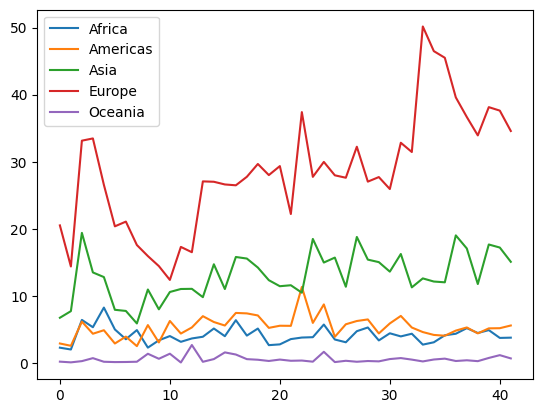

In [51]:
for continent in continent_iso_map:
    compute_group(matches, continent, continent_iso_map[continent])